In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import StratifiedKFold

from toolbox.machine_learning import get_data, get_features_sets
from toolbox.figures import set_dtu_colors, set_matplotlib_style

# Import mutual_info_classif
from sklearn.feature_selection import mutual_info_classif

# Import the necessary modules for plotting
set_matplotlib_style()
colors = set_dtu_colors()

In [2]:
# Import simulation inputs and cluster labels
inputs = pd.read_csv('../results/simulations/present-day_inputs.csv', index_col=0)
cluster_labels = pd.read_csv('../results/simulations/present-day_cluster_labels.csv', index_col=0)
cluster_labels = cluster_labels.sort_values(by='key').reset_index(drop=True)

# Merge inputs and cluster labels into a single dataframe based on key and index
inputs = inputs.merge(cluster_labels, left_index=True, right_on='key')

# Drop unnecessary columns
inputs.drop(['type_house', 'elec_gas', 'key'], axis=1, inplace=True)

In [3]:
inputs

,floor_area,volume,orientation,wall_U_value,roof_U_value,ground_U_value,construction_type,ceiling_insulation,u_factor,shgc,window_to_wall_ratio,door_area,number_people,activity_level,P_equip,P_hvac,lighting_bulbs,infiltration_rate,cluster
0,52.960858,199.379961,45,3.35,0.174390,2.090000,1,1,1.372321,0.529771,0.114109,2.658326,9.0,134.877445,389.540048,1615.663658,3.0,0.445719,1
1,45.388881,122.802630,315,3.35,0.174033,1.218124,1,1,1.692861,0.593691,0.039233,2.077256,1.0,111.802371,47.488522,1075.336747,5.0,0.469739,1
2,46.656844,158.501730,180,3.35,0.174033,1.728701,1,1,1.237705,0.595338,0.130983,2.424799,8.0,95.473182,53.476870,1634.842032,4.0,0.374706,1
3,67.871616,281.885110,90,3.35,0.174390,1.218124,1,1,1.165207,0.571022,0.111862,3.381410,7.0,71.790752,263.902479,1775.467343,1.0,0.398482,1
4,49.317865,153.282543,270,3.35,31.500000,1.728701,1,0,1.372327,0.692081,0.100863,2.414570,3.0,74.558574,105.098427,662.219034,4.0,0.456430,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,31.645130,74.813527,270,10000.00,31.500000,2.920000,0,0,2.512042,0.574047,0.094150,2.196440,2.0,116.163096,78.246341,1328.110115,4.0,0.314862,0
436,20.956402,57.379519,225,2.92,0.174033,10.000000,0,1,1.759390,0.526537,0.023524,2.174491,5.0,143.631249,216.375958,1979.998269,4.0,0.336818,1
437,26.556461,53.900867,90,2.92,31.500000,2.920000,0,0,1.695153,0.646297,0.112145,2.915418,2.0,108.194436,114.436729,1666.945069,4.0,0.279763,0
438,19.965228,52.432852,270,10000.00,0.174997,10.000000,0,1,1.901404,0.710245,0.041313,0.982925,1.0,111.724463,189.574322,1036.574164,4.0,0.572542,0


In [4]:
N = [10, 50, 100, 200, 300, len(inputs)]
n_folds = 5  # Number of cross-validation folds

sensitivity_analysis_df = pd.DataFrame()

for n in N:
    mi_scores = []
    skf_outer = StratifiedKFold(n_splits=n_folds, shuffle=True)  # Outer loop for cross-validation
    
    for train_index, test_index in skf_outer.split(inputs.drop('cluster', axis=1), inputs['cluster']):
        sensitivity_df = inputs.copy()
        sensitivity_df = sensitivity_df.sample(n=n)
        X = sensitivity_df.drop('cluster', axis=1)
        y = sensitivity_df['cluster']
        
        skf_inner = StratifiedKFold(n_splits=n_folds, shuffle=True)  # Inner loop for cross-validation
        
        for train_index_inner, test_index_inner in skf_inner.split(X, y):
            X_train, X_test = X.iloc[train_index_inner], X.iloc[test_index_inner]
            y_train, y_test = y.iloc[train_index_inner], y.iloc[test_index_inner]

            mi_scores_fold = mutual_info_classif(X_train, y_train)
            mi_scores.append(mi_scores_fold)
    
    mi_scores = np.array(mi_scores)
    avg_mi_scores = np.mean(mi_scores, axis=0)
    
    sensitivity_analysis = pd.DataFrame({'Features': X.columns, 'Mutual Information': avg_mi_scores})
    sensitivity_analysis.columns = ['Features', n]
    sensitivity_analysis.set_index('Features', inplace=True)

    sensitivity_analysis_df = pd.concat([sensitivity_analysis_df, sensitivity_analysis], axis=1)

    # Print the results
    print("Sensitivity Analysis - Mutual Information Scores for {} samples:\n".format(n))
    print(sensitivity_analysis)
    print("\n")

# Export the results to a CSV file
sensitivity_analysis_df.to_csv('..\\simulations\\sensitivity_analysis.csv', index=False)


c:\Users\bruno\.conda\envs\ml-env\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\bruno\.conda\envs\ml-env\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\bruno\.conda\envs\ml-env\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Sensitivity Analysis - Mutual Information Scores for 10 samples:

                            10
Features                      
floor_area            0.119310
volume                0.089655
orientation           0.034155
wall_U_value          0.079750
roof_U_value          0.146917
ground_U_value        0.134333
construction_type     0.189214
ceiling_insulation    0.026643
u_factor              0.046226
shgc                  0.105786
window_to_wall_ratio  0.057226
door_area             0.018262
number_people         0.066393
activity_level        0.015976
P_equip               0.095167
P_hvac                0.016440
lighting_bulbs        0.121798
infiltration_rate     0.011714


Sensitivity Analysis - Mutual Information Scores for 50 samples:

                            50
Features                      
floor_area            0.087014
volume                0.110820
orientation           0.051932
wall_U_value          0.245469
roof_U_value          0.272515
ground_U_value        0.13124

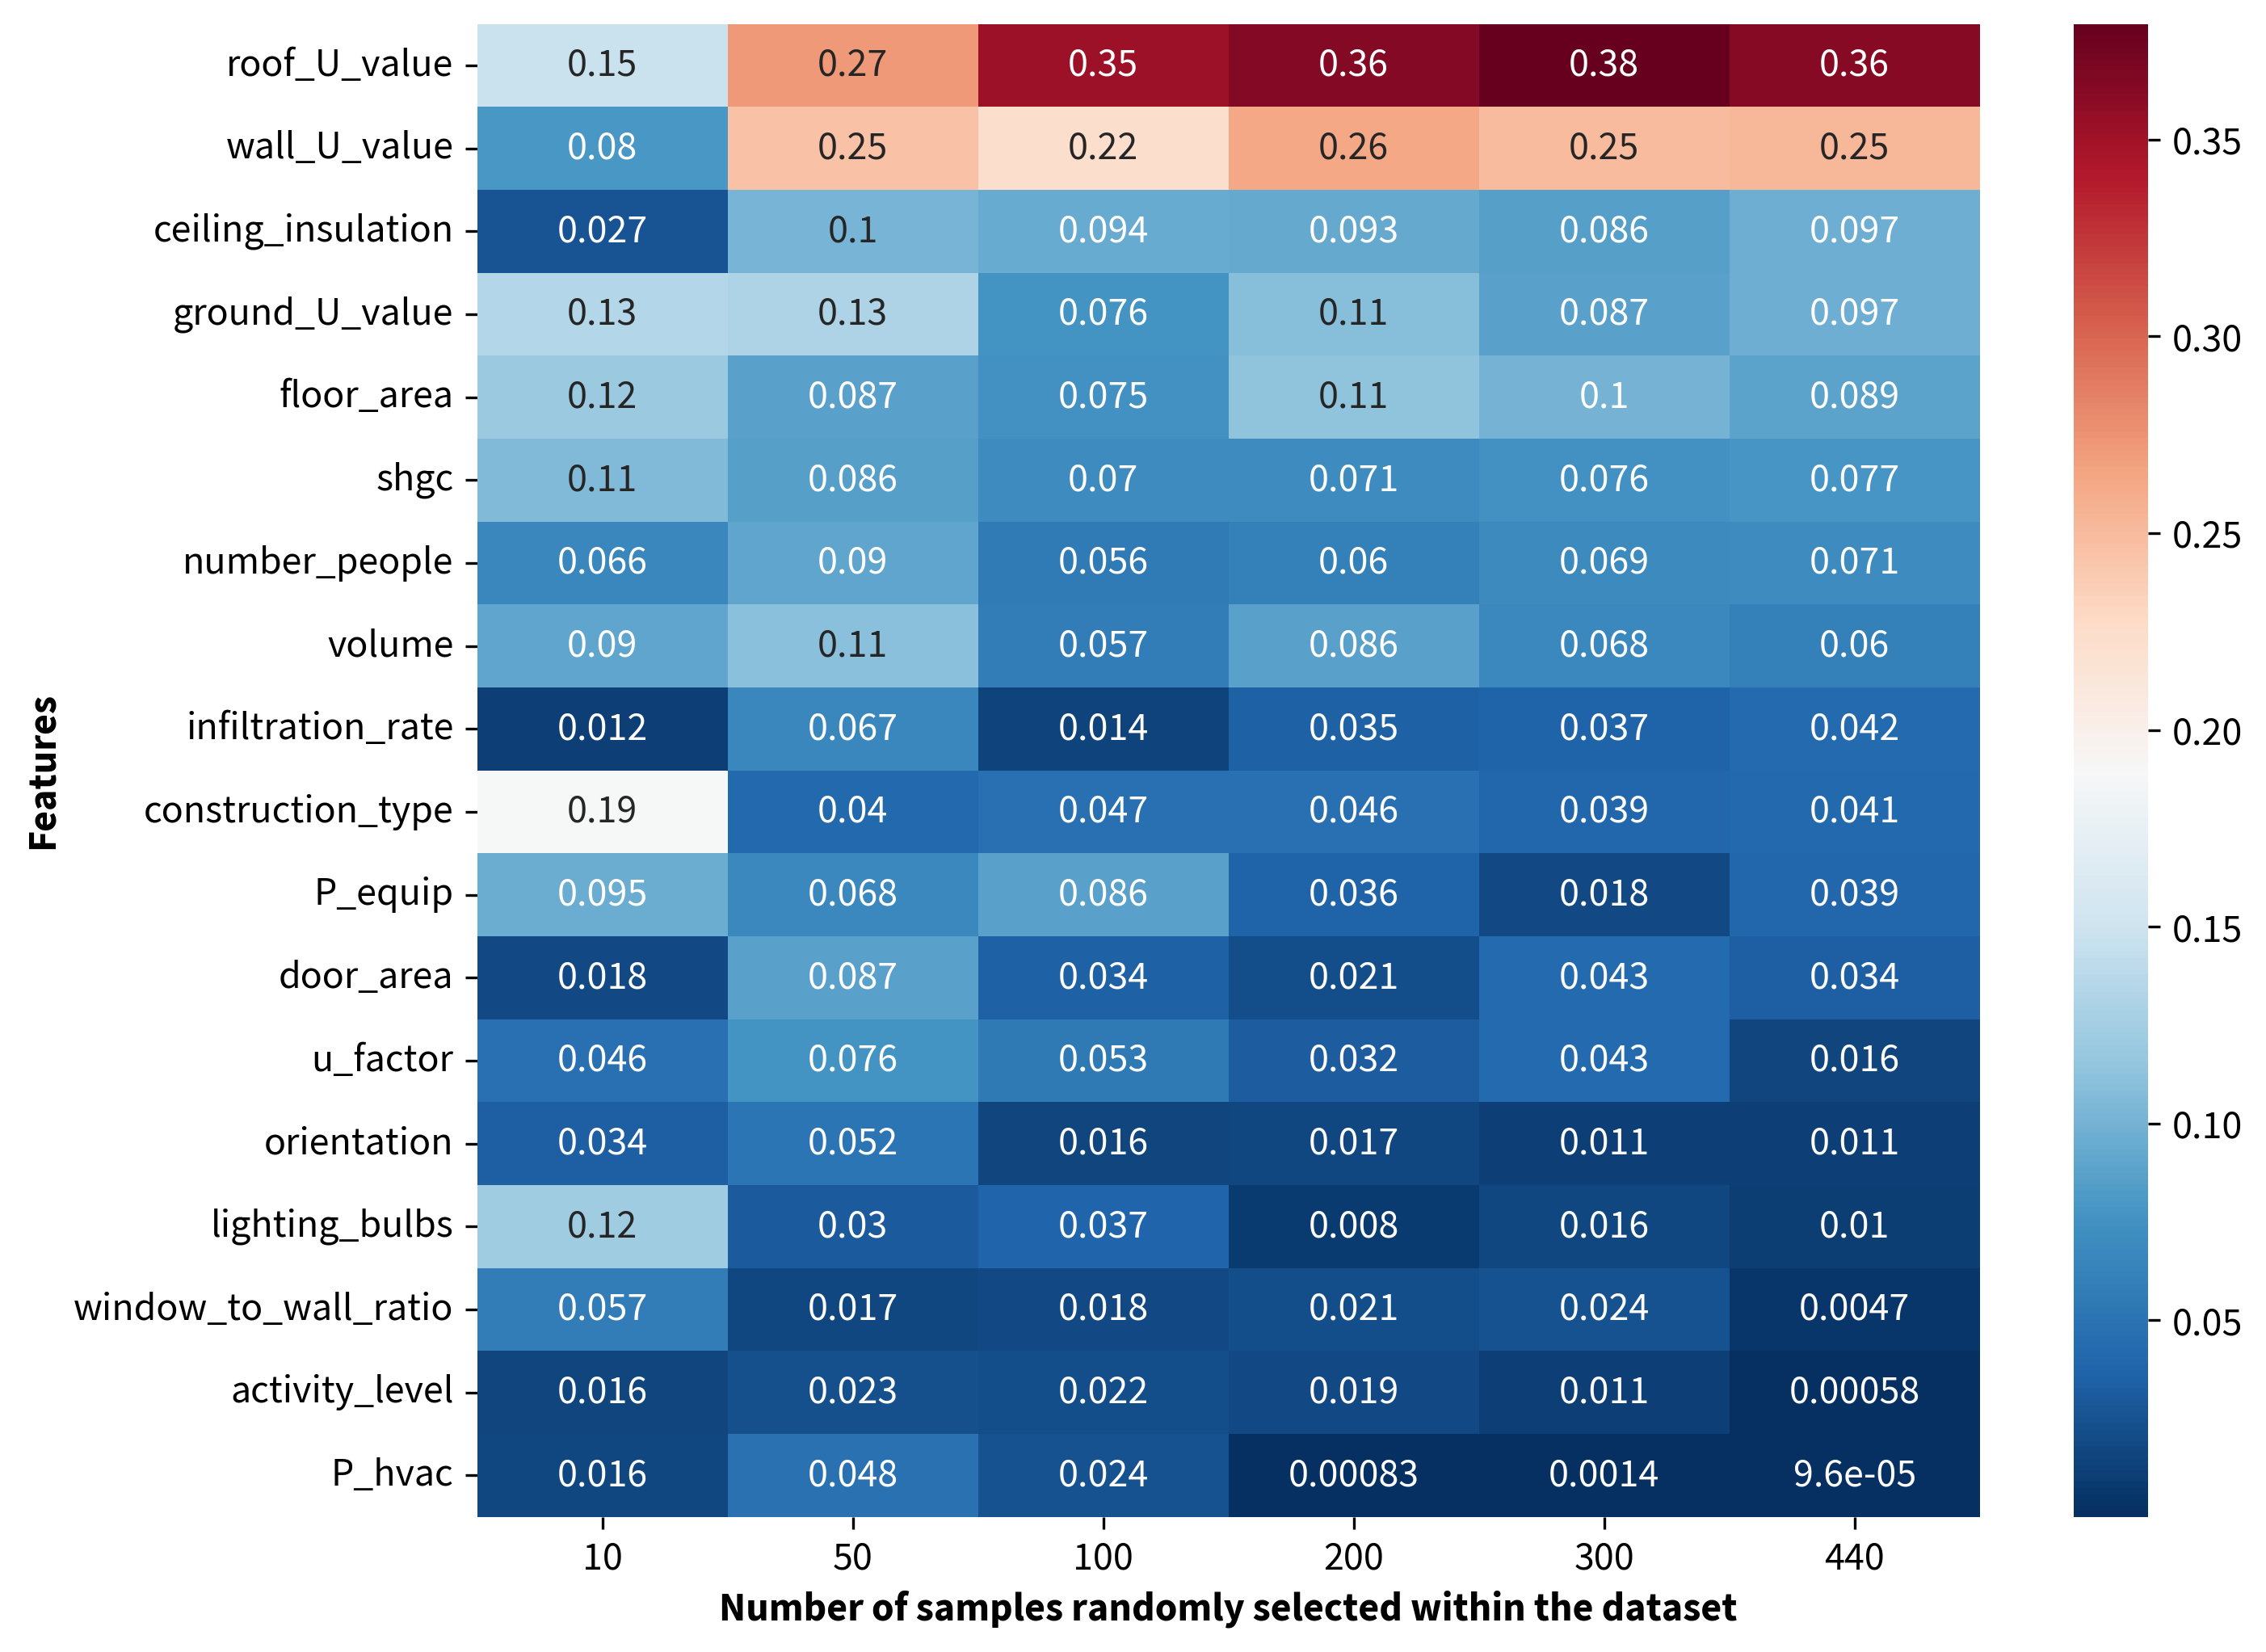

In [5]:
sensitivity_analysis_df = sensitivity_analysis_df.sort_values(len(inputs), ascending=False)

# Create the heatmap
sns.heatmap(sensitivity_analysis_df, annot=True, cmap='RdBu_r')

# Name the x axis
plt.xlabel('Number of samples randomly selected within the dataset')

# Save the figure
plt.savefig('../figures/sensitivity_analysis/mutual_information.png', dpi=300, bbox_inches='tight')
plt.show()

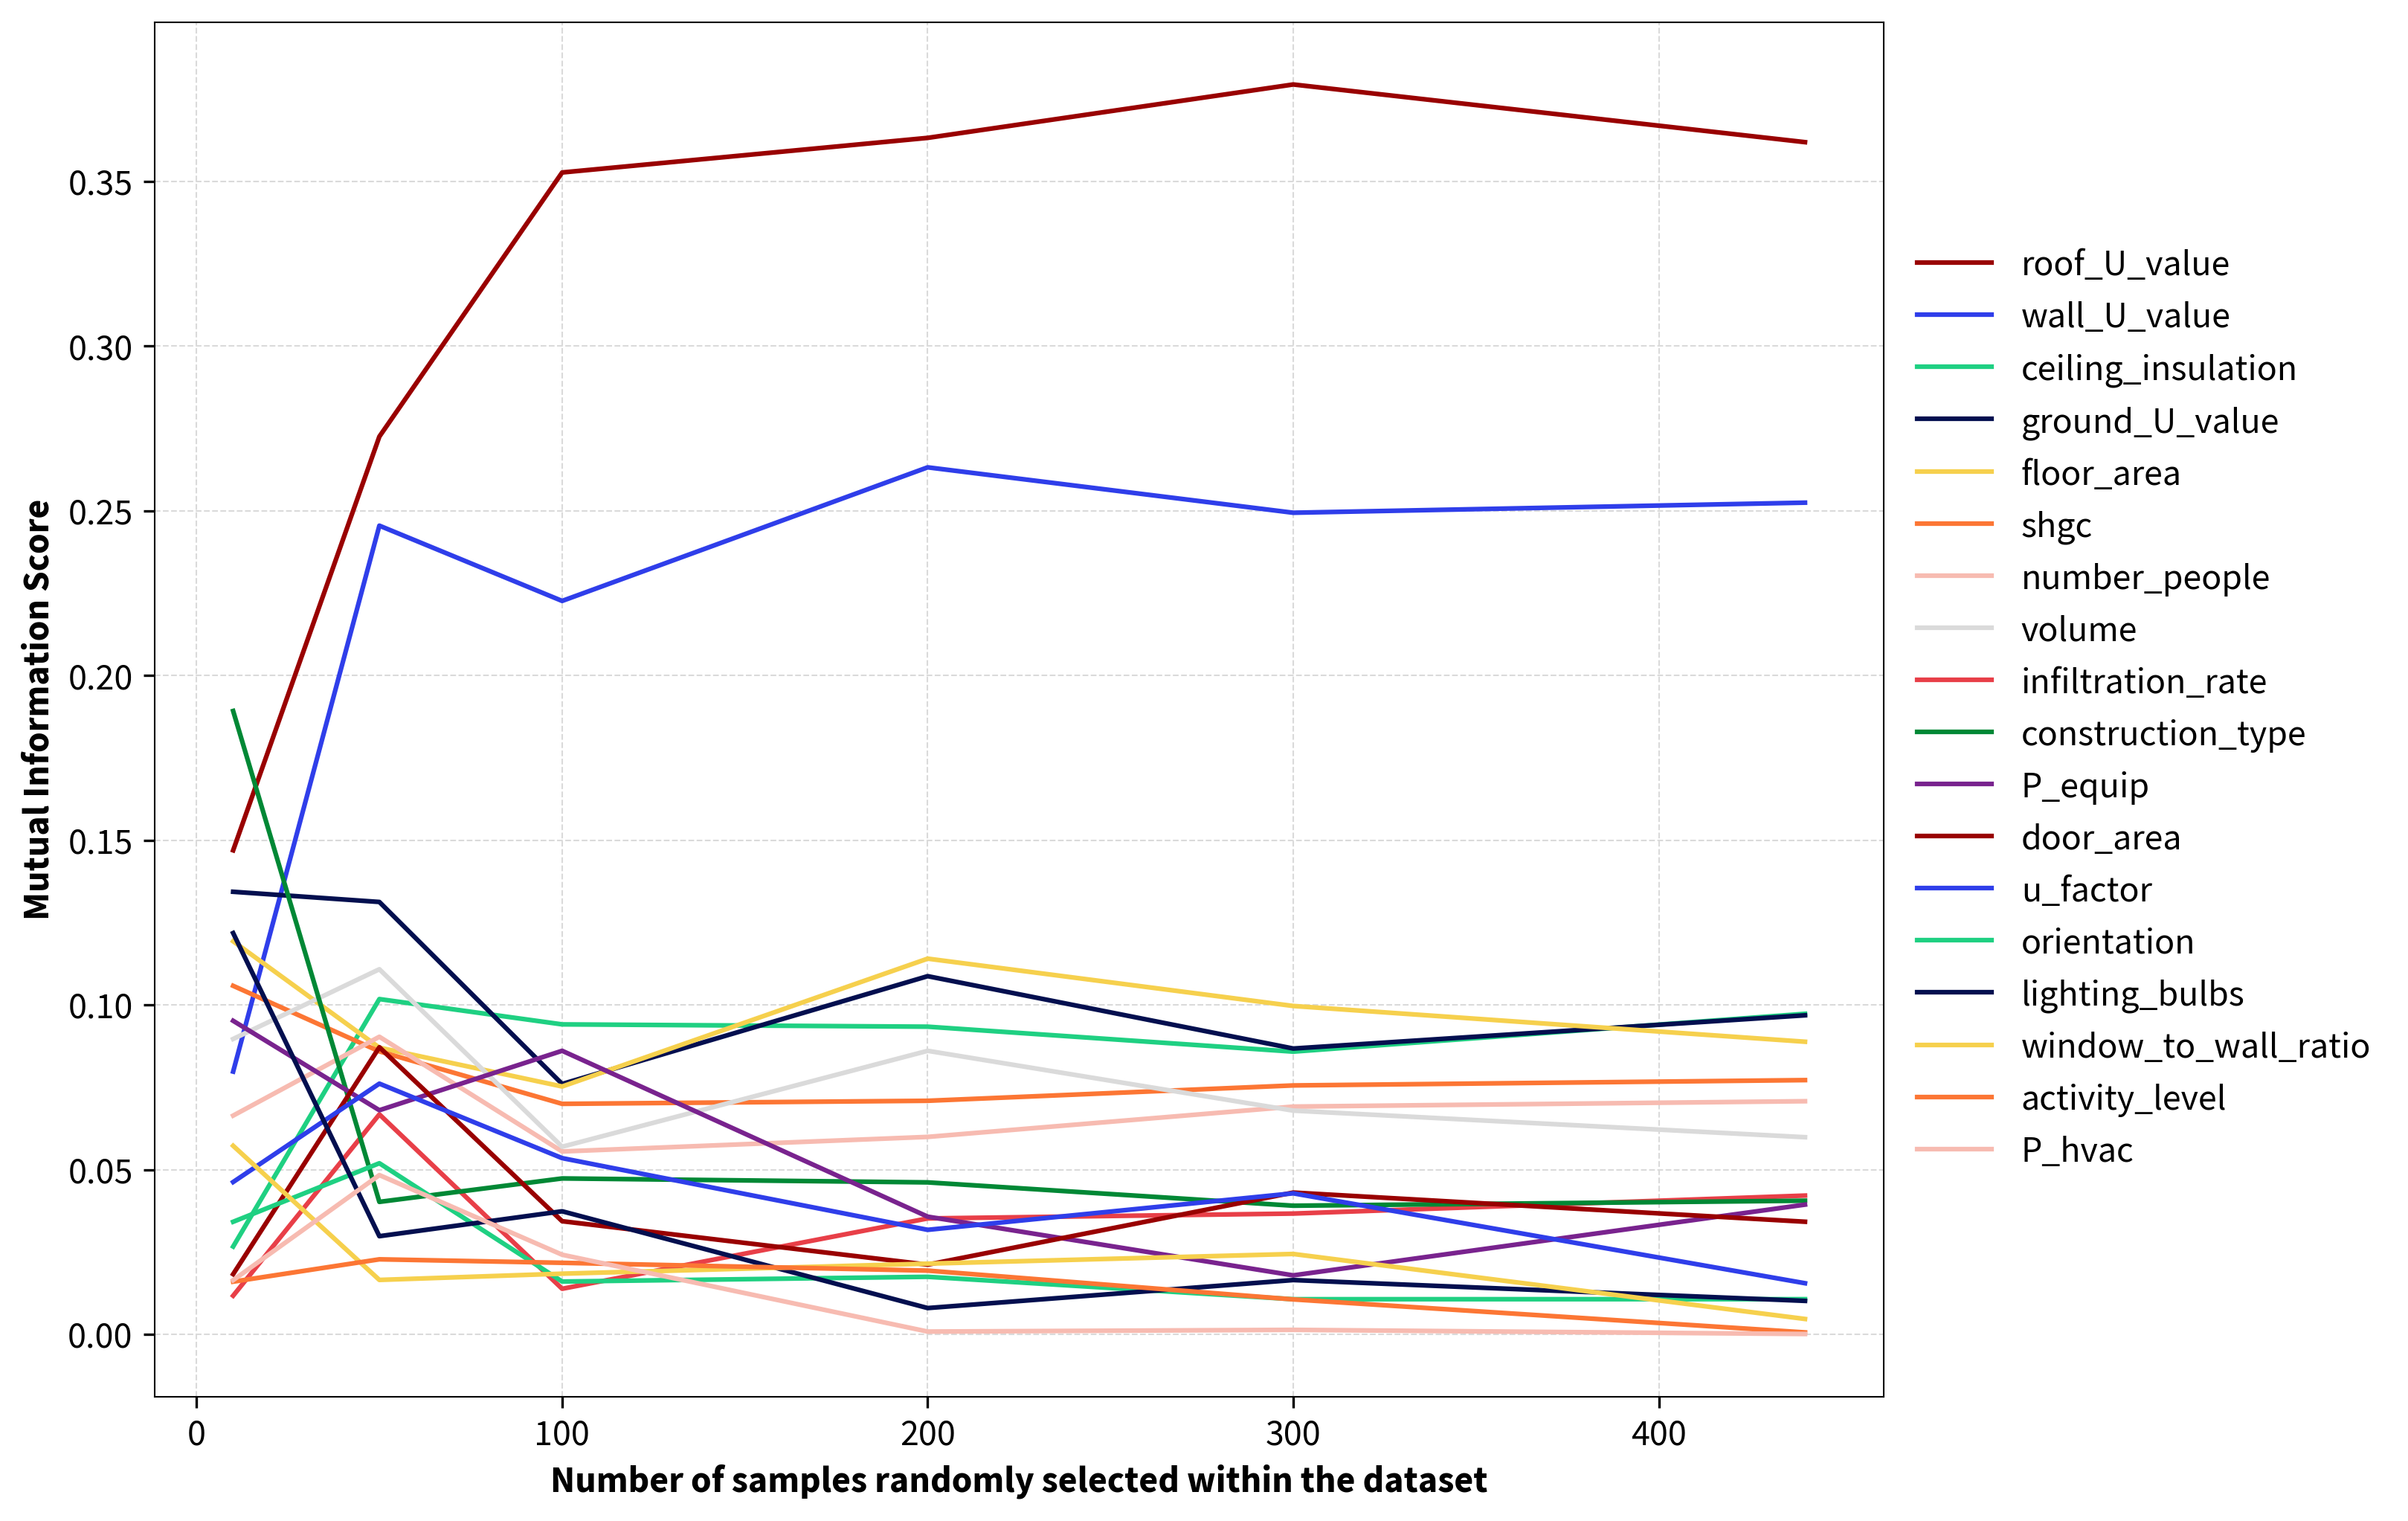

In [8]:
# Plot line chart with the mutual information scores for each feature
for feature in sensitivity_analysis_df.index:
    plt.plot(N, sensitivity_analysis_df.loc[feature, :])

# Name the x axis
plt.xlabel('Number of samples randomly selected within the dataset')

# Name the y axis
plt.ylabel('Mutual Information Score')
plt.legend(sensitivity_analysis_df.index, loc='center left', bbox_to_anchor=(1, 0.5))
# Save the figure
plt.savefig('../figures/sensitivity_analysis/mutual_information_line_chart.png', dpi=300, bbox_inches='tight')
plt.show()

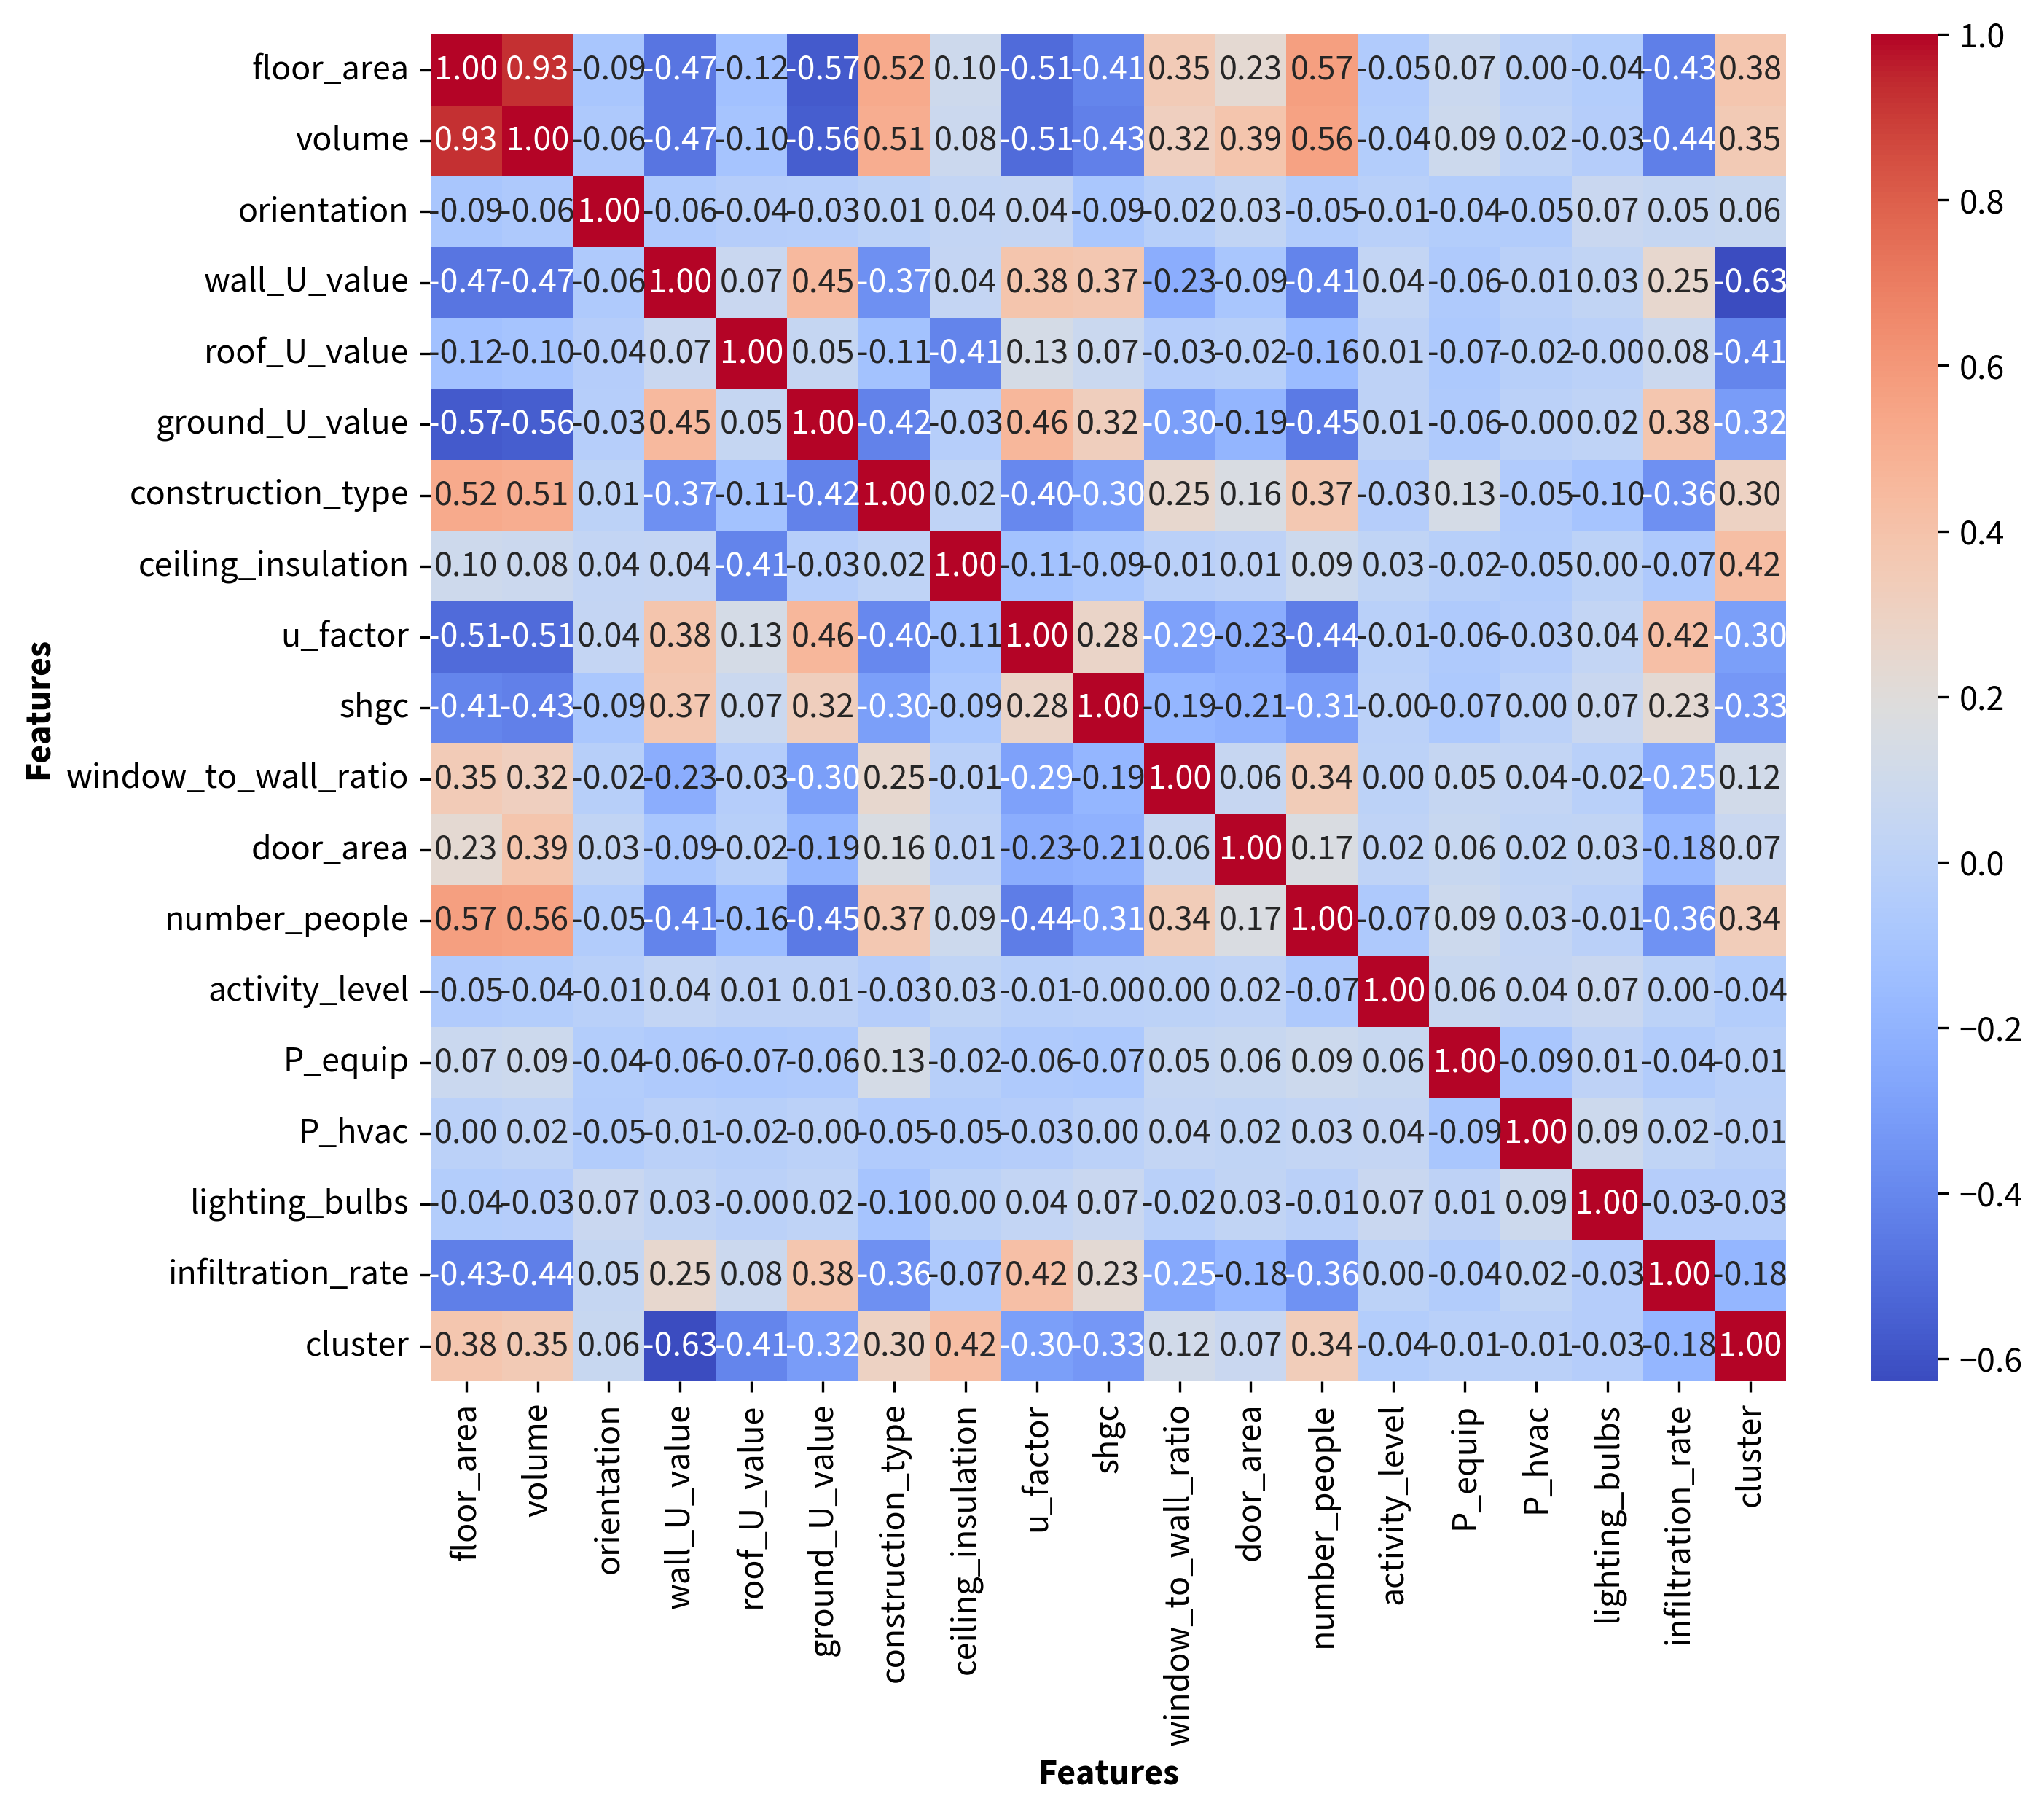

In [6]:
# Calculate the correlation matrix using Pearson's correlation coefficient
correlation_matrix = inputs.corr(method='pearson')

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')

# Name the axis
plt.xlabel('Features')
plt.ylabel('Features')
# plt.title("Correlation Matrix - Pearson's Coefficient")

# Save the figure
plt.savefig('../figures/sensitivity_analysis/correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()